# Aim

Experiment with Extended Kalman smoothing for transit parameters.

In [1]:
import batman
import lightkurve as lk
import numpy as np
import copy
import os
from matplotlib import pyplot as plt
from tqdm import notebook as tqdm
from ekf import jacobian, EKFilter

re = 0.009158
eps = 1e-6
%load_ext autoreload
%autoreload 2

In [2]:
# EKF functions for the light curve

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    https://dfm.io/posts/exopop/
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

dt = 30 / (60 * 60 * 24) # 30 minute cadence in days
mstar = 0.9707
rstar = 0.964
params = batman.TransitParams()
params.t0 = 0.
params.per = 2.4706
params.rp = 13.04 * re / rstar
params.a = get_a(params.per, mstar)
params.inc = 90.
params.ecc = 0.
params.w = 90.                      #longitude of periastron (in degrees)
params.u = [0.93, -0.23, 0, 0]      #limb darkening coefficients [u1-u4]'''
params.limb_dark = "nonlinear"       #limb darkening model
t = np.arange(0, params.per + dt, dt)
m = batman.TransitModel(params, t)
model_flux = m.light_curve(params)
err_flux = m.calc_err() / 1e6

def batman_to_partial_state(params):
    state = np.array([
        params.per,
        params.rp,
        params.inc,
        params.ecc,
        params.w
    ])
    state = np.concatenate((state, params.u))
    return state

def compute_lightcurve(state):
    global params, model_flux
    params.per, params.rp, params.inc, params.ecc, params.w = state[2:7]
    params.a = get_a(params.per, mstar)
    params.u = state[7:]
    model_flux = m.light_curve(params)
    return model_flux

def lightcurve_state_transition(state):
    '''
    Takes in a state: [flux, t_idx, period, prad, incl, ecc, omega, *limbdark1-4].
    Returns the state at the next timestep.
    '''
    if len(state.shape) > 1:
        # passing in an array from the Jacobian
        return np.vstack([lightcurve_state_transition(row) for row in state])
    if not np.allclose(batman_to_partial_state(params), state[2:]):
        # the Kalman update did something that'll need to be changed in the light curve
        compute_lightcurve(state)
    state[1] = (state[1] + 1) % len(t) # time index
    state[0] = model_flux[int(state[1])]
    return state

def lightcurve_measure(state):
    return state[0] # and PRFs and stuff later

# add in a discretization error term

Q = np.diag([
    err_flux, # var(flux) = variance of batman model flux + inherent variance
    0, # time index: no error. 
    eps, # var(period) between timesteps, should be small
    eps, # var(prad)
    eps, # var(inc)
    eps, # var(ecc)
    eps, # var(omega)
    *[eps] * len(params.u) # var(limbdarks)
])

R = np.array([[eps]]) # to be replaced by PRF stuff

In [3]:
# time to pick a TOI or KOI!
star_id = "KIC11446443"
if os.path.exists("flux_{}.npy".format(star_id)):
    lc_time, lc_flux = np.load("time_{}.npy".format(star_id)), np.load("flux_{}.npy".format(star_id))
else:
    pixelfile = lk.search_targetpixelfile(star_id, quarter=1).download(quality_bitmask='hardest')
    lc = pixelfile.to_lightcurve(aperture_mask='all')
    lc_time, lc_flux = lc.time, lc.flux
    lc_flux /= max(lc_flux)
    np.save("time_{}.npy".format(star_id), lc_time)
    np.save("flux_{}.npy".format(star_id), lc_flux)

# TIC Contamination Ratio	0.05501

In [4]:
lightcurve_filter = EKFilter(f=lightcurve_state_transition, Q=Q, h=lightcurve_measure, R=R, state=np.array([
    lc_flux[0],
    0,
    params.per,
    params.rp, # normalized prad
    90.,
    0.,
    0.,
    *[1.,0.,0.,0.]
], dtype=np.float64))

compute_lightcurve(lightcurve_filter.state)

array([0.98085362, 0.98085444, 0.98085487, ..., 0.98085455, 0.98085389,
       0.98085417])

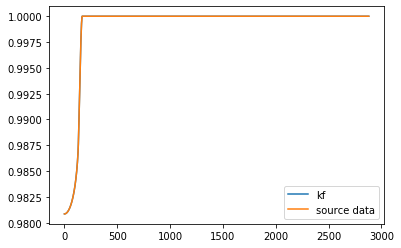

In [5]:
num_steps = 2881
kf_test_results = np.empty(num_steps)
for i in tqdm.trange(num_steps):
    lightcurve_filter.predict()
    lightcurve_filter.update(model_flux[i])
    kf_test_results[i] = lightcurve_measure(lightcurve_filter.state)
    
plt.plot(kf_test_results, label='kf')
plt.plot(model_flux[:num_steps], label='source data')
plt.legend()

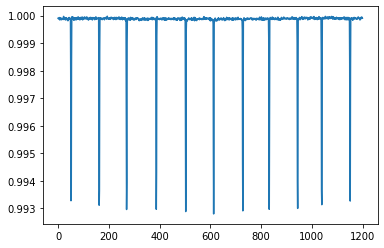

In [6]:
num_steps = 1200
kf_test_results = np.empty(num_steps)
for i in tqdm.trange(num_steps):
    lightcurve_filter.predict()
    lightcurve_filter.update(lc_flux[i])
    kf_test_results[i] = lightcurve_measure(lightcurve_filter.state)
    
plt.plot(kf_test_results, label='kf')

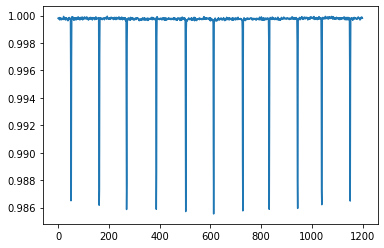

In [7]:
plt.plot(lc_flux[:num_steps])

In [8]:
lightcurve_filter.state

array([9.99906930e-01, 4.08100000e+03, 2.47060000e+00, 1.23880000e-01,
       9.00000000e+01, 8.52676280e-08, 2.28707636e-18, 1.00000001e+00,
       1.07555214e-08, 1.38061606e-08, 1.60810116e-08])